# HMM: Performance evaluation

Jacqueline R. M. A. Maasch | March 2022

## Preamble

In [1]:
# Importations.
import moses
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance
from moses.metrics import weight, logP, SA, QED
from moses.metrics.utils import get_mol, mapper
from moses import get_dataset
from collections import OrderedDict
from tdc.chem_utils import MolFilter
import warnings
from tdc import Oracle

import tdc
from tdc import Evaluator
from tdc.single_pred import HTS
from importlib.metadata import version

In [2]:
%%capture
# Installs.
#!python3.8 -m pip install fcd_torch
#!python3.8 -m pip install rxn4chemistry

## Define functions

In [3]:
def compute_tdc_metrics(generated, training):
    
    metrics_dict = dict()
    
    kl = Evaluator(name = "KL_Divergence")
    metrics_dict["KL divergence"] = kl(generated, training)

    uniqueness = Evaluator(name = "Uniqueness")
    metrics_dict["Uniqueness"] = uniqueness(generated)

    validity = Evaluator(name = "Validity")
    metrics_dict["Validity"] = validity(generated)

    novelty = Evaluator(name = "Novelty")
    metrics_dict["Novelty"] = novelty(generated, training)

    #fcd = Evaluator(name = "FCD_Distance")
    #metrics_dict["FCD distance"] = fcd(generated, training)

    diversity = Evaluator(name = "Diversity")
    metrics_dict["Diversity"] = diversity(generated)

    return metrics_dict


def remove_ungrammatical(generated):
    keep = []
    for molecule in generated:
        opening_parens = molecule.count("(")
        closing_parens = molecule.count(")")
        if opening_parens == closing_parens:
            keep.append(molecule)
    return keep


def plot_distribution(df, save_path="./plt.pdf", save=False):
    g = sns.FacetGrid(df.reset_index(), col="Metric", hue="Distribution", sharex=False)
    g.map_dataframe(sns.kdeplot, "Data", fill=True, common_norm = True).add_legend()
    if save:
        plt.savefig(save_path)
    else:
        plt.show()

## Read data

### Generated molecules

In [4]:
# Read in generated molecules.
df = pd.read_csv("comb_de_novo_2k.csv")
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  2000 non-null   object
 1   Active  2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None


,SMILES,Active
0,O=C(CCl)Nc1ccc(O)c(C2C=CS(=O)(=O)C2)c1,1
1,CO[C@@H]1O[C@H](C)C[C@@H](N(C=O)C(C)=Cc2ccc(Nc...,1
2,CC(=O)NC(=O)NCC1=C(C(=O)[O-])N2C(=O)[C@H]([C@H...,1
3,COc1ccc(-c2ccccc2)cc1CO[C@]1(C)C[C@H](C2CCC(O)...,1
4,Cc1ncc(NCn2cccn2)c(N)n1,1


In [5]:
# Disaggregate molecules sampled from active model vs inactive model.
df_active = df[df["Active"] == 1]
df_inactive = df[df["Active"] == 0]

print(df_active.info())
display(df_active.head())

print(df_inactive.info())
display(df_inactive.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  1000 non-null   object
 1   Active  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.4+ KB
None


,SMILES,Active
0,O=C(CCl)Nc1ccc(O)c(C2C=CS(=O)(=O)C2)c1,1
1,CO[C@@H]1O[C@H](C)C[C@@H](N(C=O)C(C)=Cc2ccc(Nc...,1
2,CC(=O)NC(=O)NCC1=C(C(=O)[O-])N2C(=O)[C@H]([C@H...,1
3,COc1ccc(-c2ccccc2)cc1CO[C@]1(C)C[C@H](C2CCC(O)...,1
4,Cc1ncc(NCn2cccn2)c(N)n1,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1000 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  1000 non-null   object
 1   Active  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.4+ KB
None


,SMILES,Active
1000,COc1ccc(-c2ccc(-c3ccccc3)cc2)cc1,0
1001,C[C@]12CC[C@@H]3c4ccc(O)cc4C[C@@H](NC4CCCC4=O)...,0
1002,Fc1ccc(C(Nc2ccc(Oc3ccccc3)cc2)c2ccccc2)cc1,0
1003,Cc1ccc(S(=O)(=O)[N-]Cl)cc1,0
1004,Cc1c(NCC(=O)Oc2cnn3cccnc23)cnn1C,0


### Training data from TDC

In [6]:
# Default random state seed for TDC.
# Read about split methods here: https://tdcommons.ai/functions/data_split/
# Consider scaffold split over random split in the future.
random_seed = 42

# SARS-CoV-2 In Vitro, Touret et al.
data_touret = HTS(name = "SARSCoV2_Vitro_Touret")
split_touret = data_touret.get_split(method = "random", 
                                     seed = random_seed, 
                                     frac = [0.7, 0.1, 0.2])

# SARS-CoV-2 3CL Protease, Diamond.
data_diamond = HTS(name = "SARSCoV2_3CLPro_Diamond")
split_diamond = data_diamond.get_split(method = "random", 
                                       seed = random_seed, 
                                       frac = [0.7, 0.1, 0.2])

# Explore data.
print("dataset datatype:", type(data_touret))
print("data split datatype:", type(split_touret), "\n")
display(data_touret)
print()
display(split_touret)

# Extract training / validation / testing sets.
train_touret = split_touret.get("train")
val_touret = split_touret.get("valid")
test_touret = split_touret.get("test")

train_diamond = split_diamond.get("train")
val_diamond = split_diamond.get("valid")
test_diamond = split_diamond.get("test")

Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!


dataset datatype: <class 'tdc.single_pred.hts.HTS'>
data split datatype: <class 'dict'> 



{'train':       Drug_ID                                               Drug  Y
 0           0                       CCOc1ccc2nc(S(N)(=O)=O)sc2c1  1
 1           1  C[C@]12C/C(=C/O)C(=O)C[C@@H]1CC[C@@H]1[C@@H]2C...  1
 2           2               Cc1nccn1CC1CCc2c(c3ccccc3n2C)C1=O.Cl  1
 3           3  CC(=O)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C@@H](O)CC[C...  1
 4           4  C=C1CC[C@@]2(O)[C@H]3Cc4ccc(O)c5c4[C@@]2(CCN3C...  1
 ...       ...                                                ... ..
 1034     1477                        O=C(CCCCCCC(=O)Nc1ccccc1)NO  0
 1035     1478        COc1ccccc1OCCNCC(O)COc1cccc2[nH]c3ccccc3c12  0
 1036     1481  Clc1ccc(C(Cn2ccnc2)OCc2csc3c(Cl)cccc23)c(Cl)c1...  0
 1037     1482  CCSc1ccc2c(c1)N(CCCN1CCN(C)CC1)c1ccccc1S2.O=C(...  0
 1038     1483  C=Cc1c(C)c2cc3nc(cc4[nH]c(cc5nc(cc1[nH]2)C(C)=...  0
 
 [1039 rows x 3 columns],
 'valid':      Drug_ID                                               Drug  Y
 0        581              CC(=O)OCC(CCn1cnc2cnc(N)nc21)CO

In [7]:
# Explore data splits.
print("\n~~~~~ TOURET: SARS-CoV-2 In Vitro, Touret et al. ~~~~~\n")
print("\n--- TRAINING SPLIT ---\n")
print(train_touret.Y.value_counts())
print(train_touret.Y.value_counts(normalize = True), "\n")
print(train_touret.info())
display(train_touret.head())
print("\n--- VALIDATION SPLIT ---\n")
print(val_touret.Y.value_counts())
print(val_touret.Y.value_counts(normalize = True), "\n")
print(val_touret.info())
display(val_touret.head())
print("\n--- TEST SPLIT ---\n")
print(test_touret.Y.value_counts())
print(test_touret.Y.value_counts(normalize = True), "\n")
print(test_touret.info())
display(test_touret.head())

# Explore data splits.
print("\n~~~~~ DIAMOND: SARS-CoV-2 3CL Protease, Diamond et al. ~~~~~\n")
print("\n--- TRAINING SPLIT ---\n")
print(train_diamond.Y.value_counts())
print(train_diamond.Y.value_counts(normalize = True), "\n")
print(train_diamond.info())
display(train_diamond.head())
print("\n--- VALIDATION SPLIT ---\n")
print(val_diamond.Y.value_counts())
print(val_diamond.Y.value_counts(normalize = True), "\n")
print(val_diamond.info())
display(val_diamond.head())
print("\n--- TEST SPLIT ---\n")
print(test_diamond.Y.value_counts())
print(test_diamond.Y.value_counts(normalize = True), "\n")
print(test_diamond.info())
display(test_diamond.head())


~~~~~ TOURET: SARS-CoV-2 In Vitro, Touret et al. ~~~~~


--- TRAINING SPLIT ---

0    977
1     62
Name: Y, dtype: int64
0    0.940327
1    0.059673
Name: Y, dtype: float64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1039 entries, 0 to 1038
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Drug_ID  1039 non-null   int64 
 1   Drug     1039 non-null   object
 2   Y        1039 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 24.5+ KB
None


,Drug_ID,Drug,Y
0,0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,1
1,1,C[C@]12C/C(=C/O)C(=O)C[C@@H]1CC[C@@H]1[C@@H]2C...,1
2,2,Cc1nccn1CC1CCc2c(c3ccccc3n2C)C1=O.Cl,1
3,3,CC(=O)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C@@H](O)CC[C...,1
4,4,C=C1CC[C@@]2(O)[C@H]3Cc4ccc(O)c5c4[C@@]2(CCN3C...,1



--- VALIDATION SPLIT ---

0    141
1      7
Name: Y, dtype: int64
0    0.952703
1    0.047297
Name: Y, dtype: float64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Drug_ID  148 non-null    int64 
 1   Drug     148 non-null    object
 2   Y        148 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ KB
None


,Drug_ID,Drug,Y
0,581,CC(=O)OCC(CCn1cnc2cnc(N)nc21)COC(C)=O,0
1,375,CC(=O)S[C@@H]1CC2=CC(=O)CC[C@]2(C)[C@H]2CC[C@@...,0
2,703,Nc1nc2c(ncn2CCC(CO)CO)c(=O)[nH]1,0
3,1039,NC(=O)N1c2ccccc2C=Cc2ccccc21,0
4,610,O=C(O)CCc1nc(-c2ccccc2)c(-c2ccccc2)o1,0



--- TEST SPLIT ---

0    278
1     19
Name: Y, dtype: int64
0    0.936027
1    0.063973
Name: Y, dtype: float64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Drug_ID  297 non-null    int64 
 1   Drug     297 non-null    object
 2   Y        297 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.1+ KB
None


,Drug_ID,Drug,Y
0,123,CCCCOc1cc(C(=O)NCCN(CC)CC)c2ccccc2n1,0
1,432,C[C@H](O)[C@H](O)[C@H]1CNc2nc(N)[nH]c(=O)c2N1....,0
2,1033,CS(=O)(=O)Nc1ccc([N+](=O)[O-])cc1Oc1ccccc1,0
3,529,CN1CCCCC1CCN1c2ccccc2Sc2ccc(S(C)=O)cc21.O=S(=O...,0
4,1417,CNCCCC12CCC(c3ccccc31)c1ccccc12.Cl,0



~~~~~ DIAMOND: SARS-CoV-2 3CL Protease, Diamond et al. ~~~~~


--- TRAINING SPLIT ---

0    568
1     48
Name: Y, dtype: int64
0    0.922078
1    0.077922
Name: Y, dtype: float64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Drug_ID  616 non-null    int64 
 1   Drug     616 non-null    object
 2   Y        616 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 14.6+ KB
None


,Drug_ID,Drug,Y
0,1,CC(=O)NCCc1c[nH]c2ccc(F)cc12,1
1,2,NC(=O)[C@H]1CCC[C@H]1c1ccsc1,1
2,3,CN1CCCc2ccc(S(N)(=O)=O)cc21,1
3,4,CC(=O)Nc1ccc(Oc2ncccn2)cc1,1
4,6,O=C(CCl)N1CCN(S(=O)(=O)c2ccc(Cl)cc2)CC1,1



--- VALIDATION SPLIT ---

0    78
1    10
Name: Y, dtype: int64
0    0.886364
1    0.113636
Name: Y, dtype: float64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Drug_ID  88 non-null     int64 
 1   Drug     88 non-null     object
 2   Y        88 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 2.2+ KB
None


,Drug_ID,Drug,Y
0,498,CC(=O)NCC1(c2ccccc2)CCOCC1,0
1,524,Nc1cc(C(F)(F)F)ccc1N1CCCCC1,0
2,410,Cn1cc(Oc2ncncc2Cl)cn1,0
3,233,CC1(C(N)=O)CCCN1,0
4,229,O=C(CCl)N1CCN(Cc2c(F)cccc2Cl)CC1,0



--- TEST SPLIT ---

0    156
1     20
Name: Y, dtype: int64
0    0.886364
1    0.113636
Name: Y, dtype: float64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Drug_ID  176 non-null    int64 
 1   Drug     176 non-null    object
 2   Y        176 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 4.2+ KB
None


,Drug_ID,Drug,Y
0,331,CCOc1ccc(NC(=O)NC(C)(C)C)cc1,0
1,247,C[C@H]1CN(C)CC[C@H]1CO,0
2,790,CC(C)C(=O)N1CCN(C(C)C)CC1,0
3,316,Cc1ccccc1C(=O)NC1CCN(C(=O)CCl)CC1,0
4,215,C[C@H]1NCCC[C@H]1C#N,0


In [8]:
# Agreggate all actives.
touret_pos = pd.concat([train_touret[train_touret.Y == 1],
                        val_touret[val_touret.Y == 1],
                        test_touret[test_touret.Y == 1]])

diamond_pos = pd.concat([train_diamond[train_diamond.Y == 1],
                         val_diamond[val_diamond.Y == 1],
                         test_diamond[test_diamond.Y == 1]])
df_train_active = pd.concat([touret_pos, diamond_pos])

print(df_train_active.Y.value_counts())
print(df_train_active.info())
display(df_train_active.head())

# Agreggate all inactives.
touret_neg = pd.concat([train_touret[train_touret.Y == 0],
                        val_touret[val_touret.Y == 0],
                        test_touret[test_touret.Y == 0]])

diamond_neg = pd.concat([train_diamond[train_diamond.Y == 0],
                         val_diamond[val_diamond.Y == 0],
                         test_diamond[test_diamond.Y == 0]])
df_train_inactive = pd.concat([touret_neg, diamond_neg])

print(df_train_inactive.Y.value_counts())
print(df_train_inactive.info())
display(df_train_inactive.head())

1    166
Name: Y, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 166 entries, 0 to 169
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Drug_ID  166 non-null    int64 
 1   Drug     166 non-null    object
 2   Y        166 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 5.2+ KB
None


,Drug_ID,Drug,Y
0,0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,1
1,1,C[C@]12C/C(=C/O)C(=O)C[C@@H]1CC[C@@H]1[C@@H]2C...,1
2,2,Cc1nccn1CC1CCc2c(c3ccccc3n2C)C1=O.Cl,1
3,3,CC(=O)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C@@H](O)CC[C...,1
4,4,C=C1CC[C@@]2(O)[C@H]3Cc4ccc(O)c5c4[C@@]2(CCN3C...,1


0    2198
Name: Y, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2198 entries, 62 to 175
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Drug_ID  2198 non-null   int64 
 1   Drug     2198 non-null   object
 2   Y        2198 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 68.7+ KB
None


,Drug_ID,Drug,Y
62,88,CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)C(C)(C)CCC1,0
63,89,CCC(COC(=O)c1cc(OC)c(OC)c(OC)c1)(c1ccccc1)N(C)C,0
64,90,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1,0
65,91,CC(C)=CCC1C(=O)N(c2ccccc2)N(c2ccccc2)C1=O,0
66,92,CCN1CCCC(OC(=O)C(c2ccccc2)c2ccccc2)C1.Cl,0


In [9]:
# Extract SMILES for training and generated data.
actives_train = df_train_active["Drug"]
inactives_train = df_train_inactive["Drug"]
actives_gen = df_active["SMILES"]
inactives_gen = df_inactive["SMILES"]

print("Total training actives:", len(actives_train))
print("Total training inactives:", len(inactives_train))
print("Total generated actives:", len(actives_gen))
print("Total generated inactives:", len(inactives_gen), "\n")
print(actives_train[:10])
print(actives_gen[:10])

Total training actives: 166
Total training inactives: 2198
Total generated actives: 1000
Total generated inactives: 1000 

0                         CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1    C[C@]12C/C(=C/O)C(=O)C[C@@H]1CC[C@@H]1[C@@H]2C...
2                 Cc1nccn1CC1CCc2c(c3ccccc3n2C)C1=O.Cl
3    CC(=O)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C@@H](O)CC[C...
4    C=C1CC[C@@]2(O)[C@H]3Cc4ccc(O)c5c4[C@@]2(CCN3C...
5                        C=CCOc1ccccc1OCC(O)CNC(C)C.Cl
6                       CC(C)=C/C(C)=N/Nc1nncc2ccccc12
7    CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...
8      CC1=C(/C=C/C(C)=C/C=C/C(C)=C\C(=O)O)C(C)(C)CCC1
9    COC(c1ccccc1)(c1ccccc1)[C@H](Oc1nc(C)cc(C)n1)C...
Name: Drug, dtype: object
0               O=C(CCl)Nc1ccc(O)c(C2C=CS(=O)(=O)C2)c1
1    CO[C@@H]1O[C@H](C)C[C@@H](N(C=O)C(C)=Cc2ccc(Nc...
2    CC(=O)NC(=O)NCC1=C(C(=O)[O-])N2C(=O)[C@H]([C@H...
3    COc1ccc(-c2ccccc2)cc1CO[C@]1(C)C[C@H](C2CCC(O)...
4                              Cc1ncc(NCn2cccn2)c(N)n1
5            C=C[C@H]1CN2C

## Filter molecules

>Function Description: This function identifies and removes typical not drug-like molecules (false positives) using various types of filters curated by Patrick Walters. This is a wrapper around his rd_filters GitHub package. Also checkout his blog post for more info. You can specify the rules for the filters. For example, specify what kinds of structure alerts to use and also the range for some properties. (https://tdcommons.ai/functions/data_process/#molecule-filters)[https://tdcommons.ai/functions/data_process/#molecule-filters]

In [10]:
# Remove molecules without matching parantheses.
# Note that this step is not enough to demonstrate valid SMILES syntax.
actives_grammatical = remove_ungrammatical(actives_gen)
inactives_grammatical = remove_ungrammatical(inactives_gen)

print("Total grammatical actives:", len(actives_grammatical))
print("Total ungrammatical actives:", len(actives_gen) - len(actives_grammatical))
print("Percent ungrammatical actives:", len(actives_grammatical) / len(actives_gen))
print("-------------------------------------------")
print("Total grammatical inactives:", len(inactives_grammatical))
print("Total ungrammatical inactives:", len(inactives_gen) - len(inactives_grammatical))
print("Percent ungrammatical inactives:", len(inactives_grammatical) / len(inactives_gen))

Total grammatical actives: 1000
Total ungrammatical actives: 0
Percent ungrammatical actives: 1.0
-------------------------------------------
Total grammatical inactives: 1000
Total ungrammatical inactives: 0
Percent ungrammatical inactives: 1.0


In [11]:
MolFilter?

In [12]:
# Init TDC filter.
filters = MolFilter()

MolFilter is using the following filters:
HBA: [0, 10]
HBD: [0, 5]
LogP: [-5, 5]
MW: [0, 500]
Rot: [0, 10]
Rule_BMS: True
Rule_Dundee: True
Rule_Glaxo: True
Rule_Inpharmatica: True
Rule_LINT: True
Rule_MLSMR: True
Rule_PAINS: True
Rule_SureChEMBL: True
TPSA: [0, 200]


### Actives

In [13]:
# Filter active de novo molecules.
actives_gen_filtered = filters(actives_grammatical)

In [14]:
# View filtered molecules.
print("Total active de novos post-filtering:", len(actives_gen_filtered)) 
print("-------------------------------------------")
print(actives_gen_filtered)

Total active de novos post-filtering: 330
-------------------------------------------
['COc1ccc(-c2ccccc2)cc1CO[C@]1(C)C[C@H](C2CCC(O)CC2)O[C@@H](C)[C@@H]1O'
 'NS(=O)(=O)c1ccc(-c2ccccc2)cc1' 'c1ccc(C2CC2)cc1' '[Na+]'
 'c1ccc(CSc2ccccc2)cc1' 'CCN1CCC(N(C)C)CC1' 'Clc1ccc(CCN2CCCCCC2)s1'
 'CN1CCCCC(c2ccccc2)(c2ncccn2)C1'
 'CC1OC(N[C@H](C)CCc2ccc3c(c2)OCO3)CC(C)(O)C1O'
 'c1ccc(C(CCNC2CCCN(c3ccccc3)C2)n2ccnc2)cc1' 'O=C(c1ccccc1)N1CCCCC1'
 'CN1CCN2c3ncccc3Cc3ccccc3C2C1' 'O[C@@H](COc1ccccc1)c1ccccc1'
 'Oc1cccc(Cc2ccccc2)c1' 'CN(C)C(=O)c1c[nH]c2ccc(F)cc12' 'CN(C)Cc1ccccc1'
 'O' 'Cl' 'Cl' 'c1ccc(CCN2CCCCC2)nc1' 'COCCN1CCC(C(C)(C)O)CC1' 'Cl'
 'Cc1ccc(C2(OC(C)(C)C)CCCCN(C)C2)cc1' 'CCNCc1ccc(C#N)cc1' 'Cl'
 'CCNc1ccc(C)cc1' 'Cl' 'CCOc1ccc(Cl)cc1'
 'Cc1ccc(-c2ccc(Cc3cccc(CCN)c3)cc2)cc1' 'C[C@H](CCc1ccsc1)OC1CC1'
 'O=C(O)C1CCCCC1' 'CN1CCC[C@@H]1Nc1ccnc2cc(Cl)ccc12'
 'CC1CN(Cc2ccccc2)CCO1' 'CC(CCc1ccc(Cl)cc1)NCc1ccccc1'
 'CSc1c(CNc2ncccn2)ncnc1N1Cc2ccccc2C(c2ccccc2)C1' 'CNC(=O)Cc1c(C)cccc1C'
 'O=C(Nc1

### Inactives

In [15]:
# Filter inactive de novo molecules.
inactives_gen_filtered = filters(inactives_grammatical)

In [16]:
# View filtered molecules.
print("Total inactive de novos post-filtering:", len(inactives_gen_filtered)) 
print("-------------------------------------------")
print(inactives_gen_filtered)

Total inactive de novos post-filtering: 355
-------------------------------------------
['Cc1ccc(Cn2c(=O)[nH]c3cc(Cl)ccc32)cc1' 'Cc1cc(N(C)C)no1' '[Na+]'
 'CN1CCN(C(=O)NC2CC2)CC1'
 'CC(C(=O)O)[C@H]1[C@@H](O)[C@H](O)[C@@H](O)CN1CCc1ccccc1'
 'CCOc1ncnc2nc[nH]c12' 'CN(C)CCc1cc(Cl)cc2c1OCC(=O)N2C' '[Br-]'
 'Cc1noc(Nc2ccccc2)n1' 'NC(=O)N(c1ccccc1)c1ccccc1F'
 'Fc1ccc(N2CCN(c3ccccc3Cl)CC2)c(F)c1' 'CN1CCC(NCC2CCN(CCO)CC2)CC1'
 'COC(C)C' 'NCC(=O)N1CCCCCC1' 'COc1ccnc(CNC(=O)c2ccc(F)cc2)n1' 'O'
 'O=c1cccn[nH]1' 'O=C(O)CN1C(=O)[C@@H](NCC2=NCCN2)CCc2ccccc21'
 'O=C(O)Cc1ccc2c(c1)OCO2' 'CCOc1c(Cl)nc(-c2cnn(C)c2)n1C1CCNCC1'
 'CNc1cccc(-n2nnnc2-c2ccccc2)c1'
 'CS(=O)(=O)c1ccc(N2CCC(c3cccc4c3CCC(=O)N4)CC2)cc1'
 'COCC(O)COc1cccc2c1CCC(=O)N2' 'CNCCN1c2ccccc2CCc2ccccc21'
 'CCCNc1cc2[nH]nnc2cc1-c1ccc(N2C[C@H](O)C[C@@H]2CN)cc1'
 'CC(=O)N1Cc2ccccc2C[C@@H]1Nc1ccc2c(c1)OCO2' 'c1ccc(-c2cccs2)cc1'
 'O=C(NC1CCN(C(=O)c2ccc(O)cc2)CC1)C1CCCN1' 'COc1cc(C#N)c(=O)[nH]c1C'
 'C[C@H]1C[C@H](NCCN2CCC(Oc3ccccc3)CC2)c2cc(S(N)(

### Training data

In [17]:
# Filter training data.
# Filter active de novo molecules.
actives_train_filtered = filters(list(actives_train))
inactives_train_filtered = filters(list(inactives_train))

print("Total valid training actives:", len(actives_train_filtered))
print("Total invalid training actives:", len(actives_train) - len(actives_train_filtered))
print("Percent invalid training actives:", len(actives_train_filtered) / len(actives_train))
print("-------------------------------------------")
print("Total valid training inactives:", len(inactives_train_filtered))
print("Total invalid training inactives:", len(inactives_train) - len(inactives_train_filtered))
print("Percent invalid training inactives:", len(inactives_train_filtered) / len(inactives_train))

Total valid training actives: 44
Total invalid training actives: 122
Percent invalid training actives: 0.26506024096385544
-------------------------------------------
Total valid training inactives: 803
Total invalid training inactives: 1395
Percent invalid training inactives: 0.3653321201091902


## Global-level metrics

### MOSES metrics

In [18]:
moses.get_all_metrics?

In [19]:
# Compute MOSES metrics for de novo actives.
start_time = time.time()
metrics_active = moses.get_all_metrics(gen = list(actives_gen), test = list(actives_train))
print("Complete in {} seconds.".format(time.time() - start_time))

display(metrics_active)

Complete in 56.129886865615845 seconds.


{'valid': 1.0,
 'unique@1000': 0.89,
 'unique@10000': 0.89,
 'FCD/Test': 11.961587081749485,
 'SNN/Test': 0.346468840977177,
 'Frag/Test': 0.9511806898280473,
 'Scaf/Test': 0.23091200759531483,
 'FCD/TestSF': 15.050816248532769,
 'SNN/TestSF': 0.37558236404135825,
 'Frag/TestSF': 0.8337061872677112,
 'Scaf/TestSF': 0.05913677968050712,
 'IntDiv': 0.8968132696642875,
 'IntDiv2': 0.8675210799051527,
 'Filters': 0.692,
 'logP': 0.690162263975904,
 'SA': 0.4460903005282873,
 'QED': 0.09722546292884496,
 'weight': 57.369348156626515,
 'Novelty': 0.9921348314606742}

In [20]:
display(metrics_active)

{'valid': 1.0,
 'unique@1000': 0.89,
 'unique@10000': 0.89,
 'FCD/Test': 11.961587081749485,
 'SNN/Test': 0.346468840977177,
 'Frag/Test': 0.9511806898280473,
 'Scaf/Test': 0.23091200759531483,
 'FCD/TestSF': 15.050816248532769,
 'SNN/TestSF': 0.37558236404135825,
 'Frag/TestSF': 0.8337061872677112,
 'Scaf/TestSF': 0.05913677968050712,
 'IntDiv': 0.8968132696642875,
 'IntDiv2': 0.8675210799051527,
 'Filters': 0.692,
 'logP': 0.690162263975904,
 'SA': 0.4460903005282873,
 'QED': 0.09722546292884496,
 'weight': 57.369348156626515,
 'Novelty': 0.9921348314606742}

In [21]:
# Compute MOSES metrics for de novo inactives.
start_time = time.time()
metrics_inactive = moses.get_all_metrics(gen = list(inactives_gen), train = list(inactives_train))
print("Complete in {} seconds.".format(time.time() - start_time))

display(metrics_inactive)

Complete in 63.62913227081299 seconds.


{'valid': 1.0,
 'unique@1000': 0.945,
 'unique@10000': 0.945,
 'FCD/Test': 13.406871953619628,
 'SNN/Test': 0.3679108689986169,
 'Frag/Test': 0.8717110247822509,
 'Scaf/Test': 0.16647943501680373,
 'FCD/TestSF': 14.219754532853209,
 'SNN/TestSF': 0.3548770117126405,
 'Frag/TestSF': 0.8695295611810305,
 'Scaf/TestSF': 0.015000269791277554,
 'IntDiv': 0.9038048569521904,
 'IntDiv2': 0.8841642675329617,
 'Filters': 0.79,
 'logP': 1.2790661836914032,
 'SA': 0.9554717061680631,
 'QED': 0.26316212147628204,
 'weight': 137.43454442070956,
 'Novelty': 0.9883597883597883}

### TDC metrics

In [22]:
# Compute all metrics for active de novos vs their training data.
compute_tdc_metrics(actives_gen, actives_train)

{'KL divergence': 0.9092355745604911,
 'Uniqueness': 0.89,
 'Validity': 1.0,
 'Novelty': 0.9820224719101124,
 'Diversity': 0.8931414069330533}

In [23]:
# Compute all metrics for inactive de novos vs their training data.
compute_tdc_metrics(inactives_gen, inactives_train)

{'KL divergence': 0.8897613803339549,
 'Uniqueness': 0.945,
 'Validity': 1.0,
 'Novelty': 0.9883597883597883,
 'Diversity': 0.9046137412637492}

In [24]:
# KL divergence of active training data and inactive training data.
kl = Evaluator(name = "KL_Divergence")
kl(actives_train, inactives_train)

0.8907899756080644

In [25]:
# KL divergence of active de novos and inactive training data.
kl(actives_gen, inactives_train)

0.8933037680900047

In [26]:
# KL divergence of inactive de novos and active training data.
kl(inactives_gen, actives_train)

0.889118489694653

In [27]:
# KL divergence of active de novos and inactive de novos.
kl(actives_gen, inactives_gen)

0.9471762637747988

## Molecule-level metrics

### Synthetic accessibility

>Description: Synthetic Accessibility Score stands for how hard or how easy it is to synthesize a given molecule, based on a combination of the molecule’s fragments contributions. The oracle is caluated via RDKit, using a set of chemical rules defined by Ertl et al. (https://tdcommons.ai/functions/oracles/#ibm-rxn-synthetic-accessibility)[https://tdcommons.ai/functions/oracles/#ibm-rxn-synthetic-accessibility]

In [28]:
# IBM synthetic accessibility.
# Obtain API key from: https://rxn.res.ibm.com/rxn/user/profile
#ibm = Oracle(name = "IBM_RXN")
#key = "apk-d6e326462714f9eb93ecd699f6fa06ce3ee32da5e2bcbef7e4fd56e7125957f889b11a42a682dd3b2c911bfb2d2e8fa3040cc361eda7bb6212b052e7c0ed44b00226457cbe97d334e39817bc95f64e68"
#ibm(actives_gen_filtered, key)
#ibm(actives_gen_filtered, key, output = "result")

In [29]:
# Synthetic accessibility.
sa = Oracle(name = "SA")
sa_actives_gen = sa(list(actives_gen_filtered))
sa_inactives_gen = sa(list(inactives_gen_filtered))
sa_actives_train = sa(list(actives_train))
sa_inactives_train = sa(list(inactives_train))

sa_dict = {"Generated actives": sa_actives_gen,
           "Generated inactives": sa_inactives_gen,
           "Training actives": sa_actives_train,
           "Training inactives": sa_inactives_train}

for key,value in sa_dict.items():
    print(key, ":")
    print(value[:20], "\n")

Found local copy...


Generated actives :
[3.7992534305636454, 1.3969607830406403, 1.2620812616634272, 8.479573080261886, 1.3366520142635672, 1.981891105527998, 1.9724474544682522, 2.9058371192443033, 4.077044523809392, 3.0206579555524256, 1.3205518802512373, 2.8223307307175762, 1.915899009442814, 1.4307672648666223, 2.0176449386913458, 1.2889924435985893, 5.868476923076923, 6.251046153846153, 6.251046153846153, 1.7400069593185101] 

Generated inactives :
[1.867351507627081, 2.665243391840942, 8.479573080261886, 1.87032436539344, 3.670887396179494, 2.582300242726518, 2.5804870115492147, 8.479573080261886, 2.0561543249076113, 1.8496733126097862, 1.761124389662939, 2.2071399822049322, 1.9266759347359166, 1.8308410310863117, 1.9975463794219532, 5.868476923076923, 2.5467835865240787, 3.1280379487882977, 1.8040892302583078, 2.9699928512014004] 

Training actives :
[2.198228894928752, 4.4563594992655755, 3.152523613123961, 4.079407639578063, 5.315203149844731, 2.6477496355415653, 2.720193706534902, 6.132848975793

### QED

> Description: QED stands for Quantitative Estimate of Drug-likeness. The oracle is caluated via RDKit, using a set of chemical rules about drug-likeliness defined by Bickerton et al. (https://tdcommons.ai/functions/oracles/#ibm-rxn-synthetic-accessibility)[https://tdcommons.ai/functions/oracles/]

In [30]:
# Quantitative Estimate of Drug-likeness.
qed = Oracle(name = "QED")
qed_actives_gen = qed(list(actives_gen_filtered))
qed_inactives_gen = qed(list(inactives_gen_filtered))
qed_actives_train = qed(list(actives_train))
qed_inactives_train = qed(list(inactives_train))

qed_dict = {"Generated actives": qed_actives_gen,
            "Generated inactives": qed_inactives_gen,
            "Training actives": qed_actives_train,
            "Training inactives": qed_inactives_train}

for key,value in qed_dict.items():
    print(key, ":")
    print(value[:20], "\n")

Generated actives :
[0.6799093877732707, 0.8619961908267948, 0.5312966219394869, 0.24667223026474422, 0.6752628415345541, 0.5890334307441442, 0.7803258940851515, 0.8375265880094737, 0.756830957175495, 0.6879157221540766, 0.6635330470985762, 0.7292796247091089, 0.8475932840665674, 0.7603045299219545, 0.7607800993337877, 0.5968214218758865, 0.3277476769246249, 0.3651643237938947, 0.3651643237938947, 0.7254065268981411] 

Generated inactives :
[0.7633093154900111, 0.5628493694200419, 0.24667223026474422, 0.6258457643276165, 0.5965400296751143, 0.7109534710337233, 0.8380871942460422, 0.2907254081066362, 0.7590682724597922, 0.8463211784250305, 0.8287807308953679, 0.744629756036077, 0.45127679326201153, 0.5950653599747266, 0.9066281957553696, 0.3277476769246249, 0.48454658204851075, 0.7113554189725537, 0.7383677088580421, 0.9409912162995548] 

Training actives :
[0.9002834195387214, 0.5104218936123291, 0.7209997551181788, 0.7224207015753511, 0.7802626642446739, 0.687851007974509, 0.660565627

### Octanol-water Partition Coefficient (LogP)

>Description: The penalized logP score measures the solubility and synthetic accessibility of a compound. The oracle is caluated via RDKit. (https://tdcommons.ai/functions/oracles/#ibm-rxn-synthetic-accessibility)[https://tdcommons.ai/functions/oracles/]

In [31]:
# LogP.
logp = Oracle(name = "LogP")
logp_actives_gen = logp(list(actives_gen_filtered))
logp_inactives_gen = logp(list(inactives_gen_filtered))
logp_actives_train = logp(list(actives_train))
logp_inactives_train = logp(list(inactives_train))

logp_dict = {"Generated actives": logp_actives_gen,
             "Generated inactives": logp_inactives_gen,
             "Training actives": logp_actives_train,
             "Training inactives": logp_inactives_train}

for key,value in logp_dict.items():
    print(key, ":")
    print(value[:20], "\n")

Generated actives :
[0.8564965881122057, 1.8381231174829928, 2.3924614523659025, -10.142971271684964, 3.289454120911425, 0.460994286436041, -1.0803569649598375, -2.8566490968521983, -1.6757921808042398, 1.3683117248640675, 2.1471080449841056, -3.0349923004019788, 1.7718967252130615, 2.4822073464065117, 1.0989076611289699, 1.7914057741567837, -5.496546478798415, -5.0864760929506385, -5.0864760929506385, 1.502554209116504] 

Generated inactives :
[2.2071264792003342, -0.3471870661665941, -10.142971271684964, -0.05110443298527212, -2.482571909888826, -0.45503660997981665, 0.2775872034995668, -10.142971271684964, 1.1313640265471474, 2.0211160342192653, 2.7564275130902547, -0.26785673238192254, 0.5334426089615061, -3.331328452569565, 0.8061465875331755, -5.496546478798415, -1.0968599332676003, -5.122847532723794, 0.6813502172835411, 0.13162121961490875] 

Training actives :
[0.4176466442261634, -0.15906842628465578, 0.8120953378368679, 0.37286120786020116, -19.693242150900094, 0.62329304017

### Dictionary to dataframe

In [32]:
# SA.
df_sa = pd.DataFrame()
for key,value in sa_dict.items():
    df_sa = pd.concat([df_sa, pd.DataFrame({"Distribution": [key] * len(value), "Data": value})])
df_sa["Metric"] = "SA"
display(df_sa)

,Distribution,Data,Metric
0,Generated actives,3.799253,SA
1,Generated actives,1.396961,SA
2,Generated actives,1.262081,SA
3,Generated actives,8.479573,SA
4,Generated actives,1.336652,SA
...,...,...,...
2193,Training inactives,1.674759,SA
2194,Training inactives,3.183066,SA
2195,Training inactives,2.691874,SA
2196,Training inactives,2.428605,SA


In [33]:
# QED.
df_qed = pd.DataFrame()
for key,value in qed_dict.items():
    df_qed = pd.concat([df_qed, pd.DataFrame({"Distribution": [key] * len(value), "Data": value})])
df_qed["Metric"] = "QED"
display(df_qed)

,Distribution,Data,Metric
0,Generated actives,0.679909,QED
1,Generated actives,0.861996,QED
2,Generated actives,0.531297,QED
3,Generated actives,0.246672,QED
4,Generated actives,0.675263,QED
...,...,...,...
2193,Training inactives,0.903181,QED
2194,Training inactives,0.628192,QED
2195,Training inactives,0.665903,QED
2196,Training inactives,0.688329,QED


In [34]:
# LogP.
df_logp = pd.DataFrame()
for key,value in logp_dict.items():
    df_logp = pd.concat([df_logp, pd.DataFrame({"Distribution": [key] * len(value), "Data": value})])
df_logp["Metric"] = "LogP"
display(df_logp)

,Distribution,Data,Metric
0,Generated actives,0.856497,LogP
1,Generated actives,1.838123,LogP
2,Generated actives,2.392461,LogP
3,Generated actives,-10.142971,LogP
4,Generated actives,3.289454,LogP
...,...,...,...
2193,Training inactives,2.422638,LogP
2194,Training inactives,-1.263570,LogP
2195,Training inactives,-0.875203,LogP
2196,Training inactives,-0.389376,LogP


In [35]:
# Aggregate all results.
df_metrics = pd.concat([df_sa, df_qed, df_logp]).reset_index(drop = True)
print(df_metrics.info())
display(df_metrics)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9147 entries, 0 to 9146
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Distribution  9147 non-null   object 
 1   Data          9147 non-null   float64
 2   Metric        9147 non-null   object 
dtypes: float64(1), object(2)
memory usage: 214.5+ KB
None


,Distribution,Data,Metric
0,Generated actives,3.799253,SA
1,Generated actives,1.396961,SA
2,Generated actives,1.262081,SA
3,Generated actives,8.479573,SA
4,Generated actives,1.336652,SA
...,...,...,...
9142,Training inactives,2.422638,LogP
9143,Training inactives,-1.263570,LogP
9144,Training inactives,-0.875203,LogP
9145,Training inactives,-0.389376,LogP


## Plot distributions

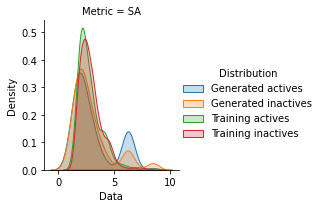

In [36]:
plot_distribution(df_sa)

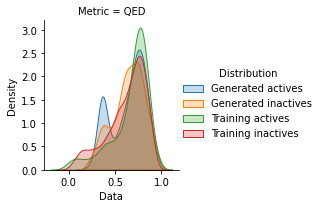

In [37]:
plot_distribution(df_qed)

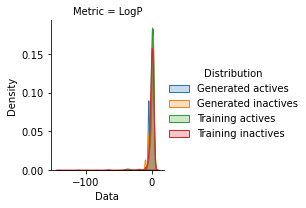

In [38]:
plot_distribution(df_logp)

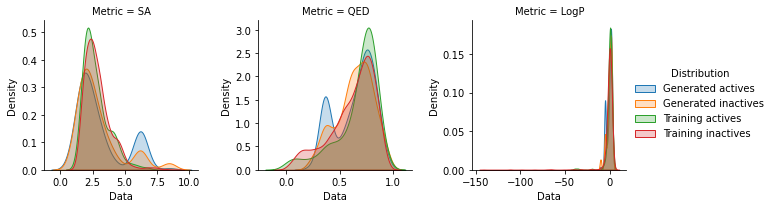

In [39]:
g = sns.FacetGrid(df_metrics.reset_index(), col="Metric", hue="Distribution", sharex=False, sharey=False)
g.map_dataframe(sns.kdeplot, "Data", fill=True, common_norm = True).add_legend()
plt.savefig("comb_metric_all.pdf")

## End of document